# Chapter 20: Text Mining


> (c) 2019-2020 Galit Shmueli, Peter C. Bruce, Peter Gedeck 
>
> _Data Mining for Business Analytics: Concepts, Techniques, and Applications in Python_ (First Edition) 
> Galit Shmueli, Peter C. Bruce, Peter Gedeck, and Nitin R. Patel. 2019.
>
> Date: 2020-03-08
>
> Python Version: 3.8.2
> Jupyter Notebook Version: 5.6.1
>
> Packages:
>   - dmba: 0.0.12
>   - matplotlib: 3.2.0
>   - nltk: 3.4.4
>   - numpy: 1.18.1
>   - pandas: 1.0.1
>   - scipy: 1.4.1
>   - scikit-learn: 0.22.2
>
> The assistance from Mr. Kuber Deokar and Ms. Anuja Kulkarni in preparing these solutions is gratefully acknowledged.


In [1]:
# import required packages for this chapter
from pathlib import Path
from zipfile import ZipFile
import math

import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
from sklearn.metrics import pairwise
from sklearn.pipeline import make_pipeline
from sklearn import linear_model
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.cluster import KMeans
import nltk
from nltk import word_tokenize
from nltk.stem.snowball import EnglishStemmer 

import matplotlib.pylab as plt

from dmba import classificationSummary

%matplotlib inline
# warning expected

/Users/gedeck/opt/anaconda3/envs/dmba-notebooks/lib/python3.8/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_extraction.stop_words module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_extraction.text. Anything that cannot be imported from sklearn.feature_extraction.text is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
# Working directory:
#
# We assume that data are kept in the same directory as the notebook. If you keep your 
# data in a different folder, replace the argument of the `Path`
DATA = Path('.')
# and then load data using 
#
# pd.read_csv(DATA / ‘filename.csv’)

In [3]:
# warning expected
# Download required files for nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /Users/gedeck/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# Problem 20.1: Tokenization
Consider the following text version of a post to an online learning forum in a statistics course: 

```
Thanks John!<br /><br /><font size="3">
&quot;Illustrations and demos will be 
provided for students to work through on 
their own&quot;</font>. 
Do we need that to finish project? If yes, 
where to find the illustration and demos? 
Thanks for your help.\<img title="smile" 
alt="smile" src="\url{http://lms.statistics.
com/pix/smartpix.php/statistics_com_1/s/smil
ey.gif}" \><br /> <br />
```

## Solution 20.1.a
Identify 10 non-word tokens in the passage.

Punctuation, such as:  !, ;, comma.  Also components of the html code like <, >, \, img, 
alt, title, src, font.  Also the url and the &quot.


## Solution 20.1.b
Suppose this passage constitutes a document to be classified, but you are not certain of the business goal of the classification task.  Identify material (at least 20\% of the terms) that, in your judgment, could be discarded fairly safely without knowing that goal.

Everything in the top row and the bottom three rows could be discarded.

## Solution 20.1.c
Suppose the classification task is to predict whether this post requires the attention of the instructor, or whether a teaching assistant might suffice.  Identify the 20\% of the terms that you think might be most helpful in that task.

The phrases "do we need to finish project" and "where to find illustrations and demos".

## Solution 20.1.d
What aspect of the passage is most problematic from the standpoint of simply using a bag-of-words approach, as opposed to an approach in which meaning is extracted?

It is probably the fact that, in this post, there are two voices - that of the
inquirer and that of the responder.  A bag of words jumbles this all together, 
and any meaning associated with there being two voices is lost.

# Problem 20.2: Classifying Internet Discussion Posts
In this problem, you will use the data and scenario described in this chapter's example, in which the task is to develop a model to classify documents as either auto-related or electronics-related. 

## Solution 20.2.a
Load the zipped file into Python and create a label vector. 

In [4]:
# Step 1: import and label records
corpus = []
label = []
with ZipFile(DATA / 'AutoAndElectronics.zip') as rawData:
    for info in rawData.infolist():
        if info.is_dir(): 
            continue
        label.append(1 if 'rec.autos' in info.filename else 0)
        corpus.append(rawData.read(info))

There are two distinct classes, electronics (labeled as 0) and autos
(labeled as 1). Reviewing some random files from these groups can 
give some idea of which category they pertain to.

## Solution 20.2.b
Following the example in this chapter, preprocess the documents.

Explain what would be different if you did not perform the 'stemming' step.

In [5]:
# Step 2: preprocessing (tokenization, stemming, and stopwords)
class LemmaTokenizer(object):
    def __init__(self):
        self.stemmer = EnglishStemmer()
        self.stopWords = set(ENGLISH_STOP_WORDS)

    def __call__(self, doc):
        return [self.stemmer.stem(t) for t in word_tokenize(doc) 
                if t.isalpha() and t not in self.stopWords]


preprocessor = CountVectorizer(tokenizer=LemmaTokenizer(), stop_words='english', encoding='latin1')
preprocessedText = preprocessor.fit_transform(corpus)


# Step 3: TF-IDF and latent semantic analysis
tfidfTransformer = TfidfTransformer()
tfidf = tfidfTransformer.fit_transform(preprocessedText)

If we don't perform stemming there will be more columns in the resulting matrix. 
Stemming strips words down to their "stems" or "roots", hence reducing the 
dimension of the resulting dataset.


## Solution 20.2.c
Use the LSA to create 10 concepts. Explain what is different about the concept matrix, as opposed to the TF-IDF matrix.

In [6]:
# Extract 20 concepts using LSA ()
svd = TruncatedSVD(10)
normalizer = Normalizer(copy=False)
lsa = make_pipeline(svd, normalizer)

lsa_tfidf = lsa.fit_transform(tfidf)

The Term Frequency matrix gives the number (the count) of times the term 
appears in the document and enter this value into the corresponding row/column
in the output matrix. 

TF-IDF compensates for the overall frequency of the term throughout the corpus
terms that appear frequently throughout the corpus are given a low value; 
high values of TF-IDF occur when a relatively rare term occurs frequently in 
one document.

The concept matrix is smaller - grouping similar terms together.

## Solution 20.2.d 
Using this matrix, fit a predictive model (different from the model presented in the chapter illustration) to classify documents as autos or electronics.  Compare its performance to that of the model presented in the chapter illustration.

We use a decision tree and a random forest classifier here.

In [7]:
# split dataset into 60% training and 40% test set
from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(lsa_tfidf, label, test_size=0.4, random_state=42)

# run decision tree model on training
dt = DecisionTreeClassifier(random_state=1)
dt.fit(Xtrain, ytrain)

# print confusion matrix and accuracty
classificationSummary(ytest, dt.predict(Xtest))

# run random forest classifier model on training
rf = RandomForestClassifier(n_estimators=500, random_state=1)
rf.fit(Xtrain, ytrain)

# print confusion matrix and accuracty
classificationSummary(ytest, rf.predict(Xtest))

Confusion Matrix (Accuracy 0.9313)

       Prediction
Actual   0   1
     0 375  22
     1  33 370


Confusion Matrix (Accuracy 0.9613)

       Prediction
Actual   0   1
     0 388   9
     1  22 381


The accuracies of the different models are:

- Logistic regression: 0.9563
- Decision tree: 0.9413
- Random forest: 0.9600

The random forest classifier performs better than the logistic regression model. The decision tree classifier performs worse.

# Problem 20.3: Classifying Classified Ads Submitted Online
Consider the case of a website that caters to the needs of a specific farming community, and carries classified ads intended for that community.  Anyone, including robots, can post an ad via a web interface, and the site owners have problems with ads that are fraudulent, spam, or simply not relevant to the community.  They have provided a file with 4143 ads, each ad in a row, and each ad labeled as either -1 (not relevant) or 1 (relevant).
The goal is to develop a predictive model that can classify ads automatically.

- Open the file `farm-ads.csv`, and briefly review some of the relevant and non-relevant ads to get a flavor for their contents. 
- Following the example in the chapter, preprocess the data in Python, and create a term-document matrix, and a concept matrix. Limit the number of concepts to 20.

In [8]:
farm_ads = pd.read_csv(DATA / 'farm-ads.csv', names=['relevance', 'text'])

print('{} relevant ads'.format(len(farm_ads[farm_ads.relevance == 1])))
print(farm_ads[farm_ads.relevance == 1].head())

print('{} non-relevant ads'.format(len(farm_ads[farm_ads.relevance == -1])))
print(farm_ads[farm_ads.relevance == -1].head())

2210 relevant ads
      relevance                                               text
1933          1   ad-abdominal ad-aortic ad-aneurysm ad-million...
1934          1   ad-ac ad-montana ad-ranch ad-horse ad-cattle ...
1935          1   ad-acai ad-pure ad-product ad-amazon title-ac...
1936          1   ad-acclaim ad-website ad-builder ad-design ad...
1937          1   ad-acclaim ad-website ad-builder ad-design ad...
1933 non-relevant ads
   relevance                                               text
0         -1   ad-abdominal ad-aortic ad-aneurysm ad-doctorf...
1         -1   ad-abdominal ad-aortic ad-aneurysm ad-million...
2         -1   ad-absorbent ad-oil ad-snar ad-factory ad-dir...
3         -1   ad-acid ad-reflux ad-relief ad-top ad-treatme...
4         -1   ad-acid ad-reflux ad-symptom ad-acid ad-reflu...


In [9]:
count_vect = CountVectorizer(token_pattern='[a-zA-Z-]+')
tfidfTransformer = TfidfTransformer(smooth_idf=False, norm=None)

counts = count_vect.fit_transform(farm_ads['text'])
tfidf = tfidfTransformer.fit_transform(counts)

In [10]:
# Extract 20 concepts using LSA ()
svd = TruncatedSVD(20)
normalizer = Normalizer(copy=False)
lsa = make_pipeline(svd, normalizer)

lsa_tfidf = lsa.fit_transform(tfidf)

## Solution 20.3.a
Examine the term-document matrix.

### Solution 20.3.a.i
Is it sparse or dense?

In [11]:
shape = counts.shape
print('Term-document matrix: {0[1]} terms, {0[0]} documents'.format(shape))
print('  number of non-zero terms: {}'.format(counts.count_nonzero()))
print('  sparsity: {:.0f}%\n'.format(100 * counts.count_nonzero() / (shape[0] * shape[1])))

Term-document matrix: 58047 terms, 4143 documents
  number of non-zero terms: 640792
  sparsity: 0%



The matrix is sparse

### Solution 20.3.a.ii
Find two non-zero entries and briefly interpret their meaning, in words (you do not need to derive their calculation)


In [12]:
# we know that 'add' occurs frequently in one of the document, but you could pick any term that has 1 or more counts 
fromTerm = 5340
toTerm = 5350
# print(counts[11,1])
index = count_vect.get_feature_names()[fromTerm:toTerm]
pd.DataFrame(data=counts[0:20,fromTerm:toTerm].toarray().transpose(), index=index)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
adconfirm,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
adconfirmemail,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
adconfirmemailaddress,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
adconfirmemailaddressreceive,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
add,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0
addadhdadrenalfatigueagelongevityallergyfood,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
addax,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
addchoice,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
addcommentadminpage,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
addcompare,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Document 7 - term 5344:  3
Document 8 - term 5344:  0
Average occurrence of term 5344 in all documents: 0.5614289162442674


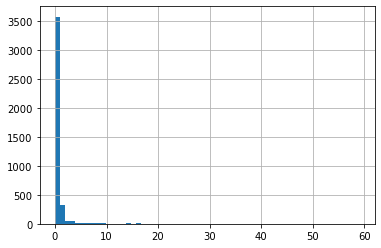

In [13]:
print('Document 7 - term 5344: ', counts[7, 5344])
print('Document 8 - term 5344: ', counts[8, 5344])
print('Average occurrence of term 5344 in all documents:', np.sum(counts[:, 5344]) / counts.shape[0])
pd.Series([c.toarray()[0, 0] for c in counts[:, 5344]]).hist(bins=60)

The term-document matrix has a 3 in the cell at row 7 and column 5344. This means the term `add` occurs 3 times in document 7. This is relatively frequent as we can see from the histogram that it rarely occurs in the other documents. 

At row 8 and column 5344, the value is 0. This meanst the term did not occur in document 8. 

## Solution 20.3.b
Briefly explain the difference between the term-document matrix and the concept-document matrix.  Relate the latter to what you learned in the principal components chapter (Chapter 4 Dimension Reduction).


The Term-Document Matrix is a matrix that indicates whether, or how often, a
term (column) appears in a document (row).  In the Concept - Document Matrix,
we must first join together similar terms into a limited number of concepts, 
which are the columns.  The documents will be listed down the left side of the
matrix. Principle Component Analysis produces linear combinations of correlated
predictor variables, and produces new predictor variables, of which a limited 
set can effectively replace the numerous original variables. 
The concept-document matrix works on the same logic using latent semantic 
indexing which results in combining related terms to produce concepts. This 
reduces the dimension of the data.

## Solution 20.3.c
Using logistic regression, partition the data (60\% training, 40\% validation), and develop a model to classify the documents as `relevant' or `non-relevant.' Comment on its efficacy.

In [14]:
# split dataset into 60% training and 40% validation set
train_X, valid_X, train_y, valid_y = train_test_split(lsa_tfidf, farm_ads.relevance, test_size=0.4, random_state=42)

# run logistic regression model on training
logit_reg = linear_model.LogisticRegression(solver='lbfgs')
logit_reg.fit(train_X, train_y)

# print confusion matrix and accuracty
classificationSummary(valid_y, logit_reg.predict(valid_X), class_names=logit_reg.classes_)

Confusion Matrix (Accuracy 0.7823)

       Prediction
Actual  -1   1
    -1 554 239
     1 122 743


The Logistic Regression model classifies the documents (as 1's or 0's) with an
error rate of 22%, according to the validation data confusion matrix. The goal
of the model is not to select out a subset of ads most likely to be relevant,
but rather to classify all ads.


## Solution 20.3.d
Why use the concept-document matrix, and not the term-document matrix, to provide the predictor variables?

We use the concept-document matrix, rather than the term document matrix, to
provide predictor variables, because the former reduces the dimension of the 
data (i.e. reduces the number of predictor variables) without sacrificing much
predictive power, allowing for easier and more effective modeling.

# Problem 20.4: Clustering auto posts
In this problem, you will use the data and scenario described in this chapter's example.  The task is to cluster the auto posts. 

## Solution 20.4.a
Following the example in this chapter, preprocess the documents, except do not create a label vector. 

In [15]:
# Step 1: import and label records
corpus = []
with ZipFile(DATA / 'AutoAndElectronics.zip') as rawData:
    for info in rawData.infolist():
        if info.is_dir(): 
            continue
        corpus.append(rawData.read(info))

# Step 2: preprocessing (tokenization, stemming, and stopwords)
class LemmaTokenizer(object):
    def __init__(self):
        self.stemmer = EnglishStemmer()
        self.stopWords = set(ENGLISH_STOP_WORDS)

    def __call__(self, doc):
        return [self.stemmer.stem(t) for t in word_tokenize(doc) 
                if t.isalpha() and t not in self.stopWords]

preprocessor = CountVectorizer(tokenizer=LemmaTokenizer(), stop_words='english', encoding='latin1')
preprocessedText = preprocessor.fit_transform(corpus)

# Step 3: TF-IDF and latent semantic analysis
tfidfTransformer = TfidfTransformer()
tfidf = tfidfTransformer.fit_transform(preprocessedText)

## Solution 20.4.b
Use the LSA to create 10 concepts. 

In [16]:
# Extract 20 concepts using LSA ()
svd = TruncatedSVD(10)
normalizer = Normalizer(copy=False)
lsa = make_pipeline(svd, normalizer)

lsa_tfidf = lsa.fit_transform(tfidf)

## Solution 20.4.c
Before doing the clustering, state how many natural clusters you expect to find.

We can expect to find two natural clusters

## Solution 20.4.d
Perform hierarchical clustering and inspect the dendrogram. 

In [17]:
Z = linkage(lsa_tfidf, method='average')

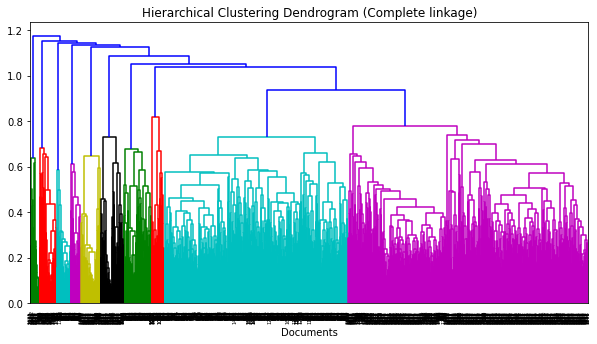

In [18]:
fig = plt.figure(figsize=(10, 6))
fig.subplots_adjust(bottom=0.23)
plt.title('Hierarchical Clustering Dendrogram (Complete linkage)')
plt.xlabel('Documents')
dendrogram(Z, color_threshold=0.9)
plt.axhline(y=8, color='black', linewidth=0.5, linestyle='dashed')
plt.show()

### Solution 20.4.d.i
From the dendrogram, how many natural clusters appear?

It appears there are two major clusters. The remaining documents form a number of smaller clusters. 

### Solution 20.4.d.ii
Examining the dendrogram as it branches beyond the number of main clusters, select a sub-cluster and assess its characteristics.

In [19]:
nclusters = 20
membership = fcluster(Z, nclusters, criterion='maxclust')
for clNumber in range(1, nclusters + 1):
    nmembers = sum(membership == clNumber)
    recAutos = ['Newsgroups: rec.autos' in str(doc) for doc, cl in zip(corpus, membership) if cl == clNumber]
    ratioAutos = sum(recAutos) /nmembers
    print(f'{sum(recAutos):3d} of {nmembers:3d} : {ratioAutos:.2f} {"rec.autos" if ratioAutos > 0.9 else ""}')

  2 of  33 : 0.06 
  7 of   7 : 1.00 rec.autos
 22 of  56 : 0.39 
 48 of  49 : 0.98 rec.autos
 38 of  38 : 1.00 rec.autos
  8 of  69 : 0.12 
  0 of  41 : 0.00 
  3 of  41 : 0.07 
 17 of  17 : 1.00 rec.autos
 83 of  84 : 0.99 rec.autos
  0 of   8 : 0.00 
 21 of  21 : 1.00 rec.autos
 16 of  18 : 0.89 
448 of 487 : 0.92 rec.autos
171 of 171 : 1.00 rec.autos
 81 of 351 : 0.23 
  0 of   7 : 0.00 
  3 of  45 : 0.07 
  1 of  25 : 0.04 
  9 of 432 : 0.02 


From this analysis, we can see that the clustering groups documents from the same newsgroup most of the times well together.

## Solution 20.4.e
Perform $k$-means clustering for two clusters and report how distant and separated they are (using between-cluster distance and within cluster dispersion).

In [20]:
kmeans = KMeans(n_clusters=2, random_state=0).fit(lsa_tfidf)

centroids = pd.DataFrame(kmeans.cluster_centers_)
print('Between-cluster distance: ', math.sqrt(sum(centroids.iloc[0, :] - centroids.iloc[1, :])**2))

Between-cluster distance:  0.8845828812990629


In [21]:
withinClusterSS = [0] * 2
clusterCount = [0] * 2
for cluster, distance in zip(kmeans.labels_, kmeans.transform(lsa_tfidf)):
    withinClusterSS[cluster] += distance[cluster]**2
    clusterCount[cluster] += 1
for cluster, withClustSS in enumerate(withinClusterSS):
    count = clusterCount[cluster]
    withinClusterDispersion = math.sqrt(withClustSS / (count - 1))
    print(f'Cluster {cluster} ({count} members): {withinClusterDispersion:5.2f} within cluster')

Cluster 0 (1087 members):  0.60 within cluster
Cluster 1 (913 members):  0.63 within cluster
